# 4. A Stochastic Dealer Model III
<br>

# 4.1. Preparation

In [1]:
% matplotlib inline
import numpy as np  # import numpy library as np
import math         # use mathematical functions defined by the C standard
import matplotlib.pyplot as plt # import pyplot library as plt 
import pandas as pd # import pandas library as pd
from numpy import fft
from datetime import datetime
plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize':16,'axes.labelsize':20,'axes.titlesize':20,
             'xtick.labelsize':12,'ytick.labelsize':12,'figure.figsize':(7.5,7.5),}
plt.rcParams.update(pltparams)

In [2]:
# Logarithmic return of price time series
def logreturn(St,tau=1):
    return np.log(St[tau:])-np.log(St[0:-tau]) # Eq.(J2) : G_tau(t) = log(S(t+tau)) - log(S(t)) 
# normalize data to have zero mean (<x> = 0) and unit variance (<(x - <x>)^2> = 1)
def normalized(data):
    return ((data-np.average(data))/np.sqrt(np.var(data)))
# compute self-correlation of vector v
def auto_correlate(v):
    # np.correlate computes C_{v}[k] = sum_n v[n+k] * v[n]
    corr = np.correlate(v,v,mode="full") # correlate returns even array [0:2*nums-1] centered at nums-1
    return corr[len(v)-1:]/len(v) # take positive values and normalize by number of points

# 4.2. The dealer model with memory (model 2)

- Price dynamics given by a random-walk with extra memory or drift term to incorporate "trend-following" behavior.

$$
p_i(t + \Delta t) = p_i(t) + d\langle\Delta P\rangle_M \Delta t + c f_i(t), \qquad i=1,2\tag{M1}
$$

$$
f_i(t) = \begin{cases}
    +\Delta p & \mathrm{prob.} 1/2 \\
    -\Delta p & \mathrm{prob.} 1/2\tag{M2}
\end{cases}
$$

- Trend-following term depends on the moving-average over the previous $M$ ticks

$$
\langle\Delta P\rangle_M = \frac{2}{M (M+1)}\sum_{k=0}^{M-1}(M-k)\Delta P(n-k)\tag{M3}
$$

- Transaction takes place when the bid price of one dealer matches the ask price of the other.

$$
\lvert p_i(t) - p_j(t) \rvert \ge L\tag{M4} 
$$

- Price return computed as

$$
  G_\tau(t) \equiv \log{P(t+\tau)} - \log{P(t)} \tag{M5} 
$$

In [3]:
def model2(params,p0,numt):
    def avgprice(dpn): # compute running average Eq.(L6)
        M = len(dpn)    # 
        weights  = np.array(range(1,M+1))*2.0/(M*(M+1))
        return weights.dot(dpn)
    
    mktprice = np.zeros(numt)   # initialize market price P(n)
    dmktprice= np.zeros(numt)   # initialize change in price dP(n) needed for running average
    ticktime = np.zeros(numt,dtype=np.int) #initialize array for tick times
    price    = np.array([p0[0], p0[1]])    #initialize dealer's mid-price (p1,p2)
    time,tick= 0,0 # real time(t) and time time (n)
    deltapm  = 0.0 # trend term d <dP>_m dt for current random walk
    cdp      = params['c']*params['dp'] # define random step size
    ddt      = params['d']*params['dt'] # define amplitude of trend term
    while tick < numt: # loop over ticks
        while np.abs(price[0]-price[1]) < params['L']: # transaction criterion Eq.(L1)
            price = price + deltapm + np.random.choice([-cdp,cdp], size=2) # random walk step Eq.(L4)
            time += 1 #update real time
        price[:]       = np.average(price) #set mid-prices to new market price Eq.(L2)
        mktprice[tick] = price[0]  # save market price
        dmktprice[tick]= mktprice[tick] - mktprice[np.max([0,tick-1])] # save dP(n) = P(n) - P(n-1)
        ticktime[tick] = time # save transaction time
        tick += 1 #update ticks
        tick0 = np.max([0, tick - params['M']]) #compute tick start for running average
        deltapm = avgprice(dmktprice[tick0:tick])*ddt #compute updated trend term for current tick time
    return ticktime,mktprice

- A simulation is performed if you run the cell below, but depending on your computer power it may take quite long time until it finishes with properly creating the simulation data "model2_M10_5d.txt".
- You may skip this cell and use pre-calculated simulation data "model2_M10_5d.txt" which can be downloaded from our website to continue further data analyses.

In [ ]:
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2, 'd':1.00, 'M':10} # define model parameters
price = np.zeros((5,5000))
# run 5 simulations with different d paramaters
for i,d,lbl in zip(range(5),[-2.0, -1.25, 0.0, 1.25, 2.0], ['d-2.0', 'd-1.25', 'd0.0', 'd+1.25', 'd+2.0']):
    np.random.seed(0)
    params['d'] = d
    print(params['d'])
    time,price[i] = model2(params, [100.25, 100.25], 5000)
np.savetxt('model2_M10_5d.txt', np.transpose(price), header="d-2\t d-1\t d0\t d+1\t d+2", comments=' ')

In [4]:
price  = pd.read_csv('model2_M10_5d.txt', header=0, delim_whitespace=True, index_col=False)
dprice = pd.DataFrame()
for lbl in price.columns:
    dprice[lbl] = normalized(logreturn(price[lbl].values, 1)) #price return G_1
dprice.head()

,d-2,d-1,d0,d+1,d+2
0,0.064483,0.064803,0.062363,0.042186,-0.093576
1,-0.249174,-0.245864,-0.235129,-0.193000,-0.100403
2,-0.759109,-0.824618,-0.909471,-0.824092,-0.120481
3,2.264443,1.994706,1.411017,0.612311,-0.087087
4,-0.453285,-0.333167,-0.215293,-0.201743,-0.102947


# 4.3. Price dynamics of the dealer model

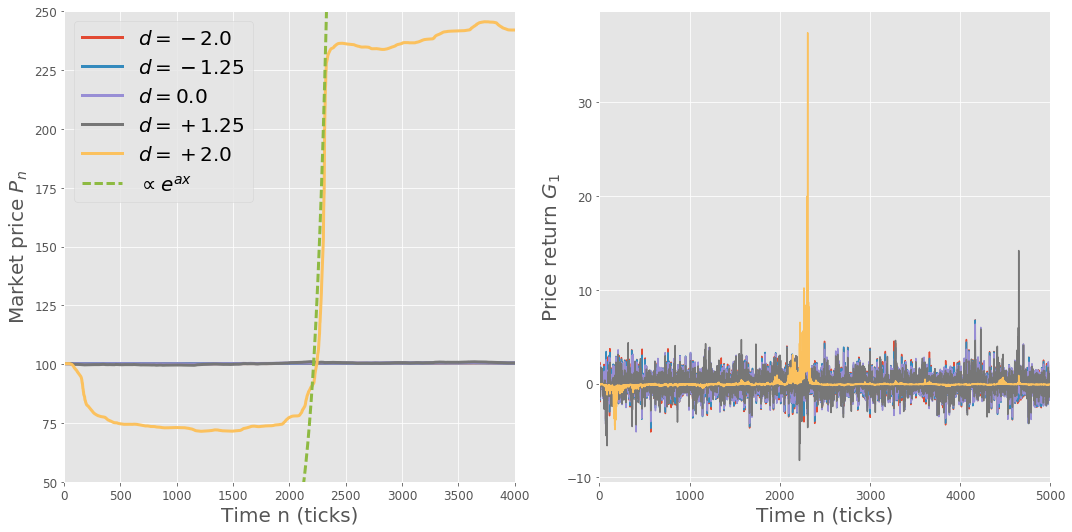

In [5]:
fig,[ax,bx]=plt.subplots(figsize=(15,7.5),ncols=2,subplot_kw={'xlabel':r'Time n (ticks)'})
price.plot(ax=ax, lw=3)
dprice.plot(ax=bx, legend=False)
x = np.arange(1000,2550)
ax.plot(x,0.03*np.exp(8e-3*(x-1200)),lw=3,ls='--',label='exponential')
ax.set_ylim(50,250)
ax.set_xlim(0,4000)
ax.legend([r'$d=-2.0$', r'$d=-1.25$', r'$d=0.0$', r'$d=+1.25$', r'$d=+2.0$', r'$\propto e^{a x}$'], loc=2, fontsize=20)
ax.set_ylabel(r'Market price $P_n$')
bx.set_ylabel(r'Price return $G_{1}$')
fig.tight_layout() # get nice spacing between plots
plt.show()

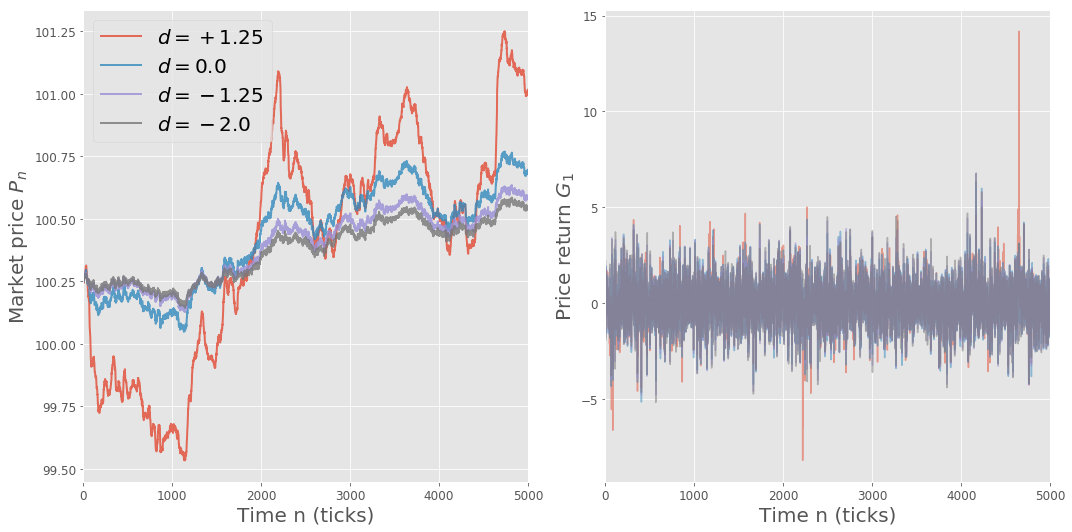

In [6]:
fig,[ax,bx]=plt.subplots(figsize=(15,7.5),ncols=2,subplot_kw={'xlabel':r'Time n (ticks)'})
cols = ['d+1','d0','d-1','d-2']
price[cols].plot(ax=ax, lw=2, alpha=0.8)
dprice[cols].plot(ax=bx, alpha=0.5, legend=False)
ax.legend([r'$d=+1.25$', r'$d=0.0$', r'$d=-1.25$', r'$d=-2.0$'], loc=2, fontsize=20)
ax.set_ylabel(r'Market price $P_n$')
bx.set_ylabel(r'Price return $G_{1}$')
fig.tight_layout() # get nice spacing between plots
plt.show()

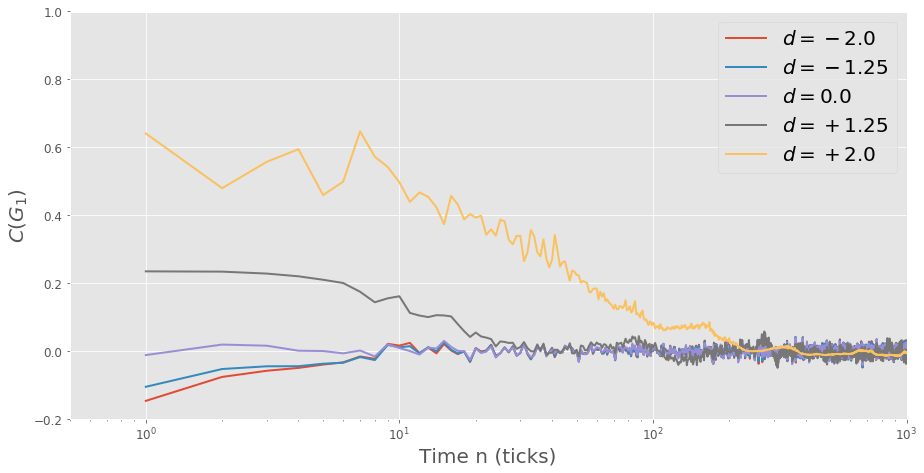

In [7]:
pricecor = pd.DataFrame()
for lbl in dprice.columns:
    ct = auto_correlate(dprice[lbl].values)
    pricecor[lbl] = ct/ct[0]
fig,ax=plt.subplots(figsize=(15,7.5),subplot_kw={'xlabel':r'Time n (ticks)', 'ylabel':r'$C(G_{1})$'})
pricecor.plot(ax=ax, lw=2)
ax.semilogx()
ax.set_xlim(5e-1,1e3)
ax.set_ylim(-0.2, 1.0)
ax.legend([r'$d=-2.0$', r'$d=-1.25$', r'$d=0.0$', r'$d=+1.25$', r'$d=+2.0$'], loc=0, fontsize=20)
plt.show()

# 4.4. Dynamics of real data

- You may use the two stock price data "US2.AAPL_170301_170301_tick.csv" and "US2.AAPL_170301_170301_min.csv" which can be downloaded from our website to continue further data analyses.

In [8]:
def computeReturn(data, pname, dname, tau):
    data[dname]=pd.Series(normalized(logreturn(data[pname].values, tau)),index=data.index[:-tau])
    
# https://www.quantshare.com/sa-426-6-ways-to-download-free-intraday-and-tick-data-for-the-us-stock-market
dateparse = lambda x: pd.datetime.strptime(x, '%Y%m%d %H:%M:%S')
appletick = pd.read_csv('US2.AAPL_170301_170301_tick.csv', parse_dates={'datetime':['Date', 'Time']}, date_parser=dateparse) #30,000 transactions over March 1 and March 2 2017
applemin  = pd.read_csv('US2.AAPL_170301_170301_min.csv',  parse_dates={'datetime':['Date', 'Time']}, date_parser=dateparse)  #minute by minute price change since the beginning of the year
computeReturn(appletick, 'Last', 'Return d1', 1)
computeReturn(applemin, 'Close', 'Return d1', 1)

In [9]:
appletick.head()

,datetime,Ticker,Per,Last,Vol,Return d1
0,2017-03-01 09:30:00,US2.AAPL,0,137.89,100,-1.503504
1,2017-03-01 09:30:00,US2.AAPL,0,137.88,100,1.467665
2,2017-03-01 09:30:00,US2.AAPL,0,137.89,100,7.408387
3,2017-03-01 09:30:00,US2.AAPL,0,137.94,100,-0.017920
4,2017-03-01 09:30:01,US2.AAPL,0,137.94,100,-0.017920


In [10]:
applemin.head()

,datetime,Ticker,Per,Open,High,Low,Close,Vol,Return d1
0,2017-03-01 09:31:00,US2.AAPL,1,137.89,138.00,137.88,137.95,12370,0.116571
1,2017-03-01 09:32:00,US2.AAPL,1,137.95,137.98,137.88,137.96,8738,-3.353714
2,2017-03-01 09:33:00,US2.AAPL,1,137.96,137.96,137.72,137.81,5005,1.201604
3,2017-03-01 09:34:00,US2.AAPL,1,137.84,137.97,137.83,137.87,7138,-0.968038
4,2017-03-01 09:35:00,US2.AAPL,1,137.88,137.88,137.79,137.83,9587,-4.877729


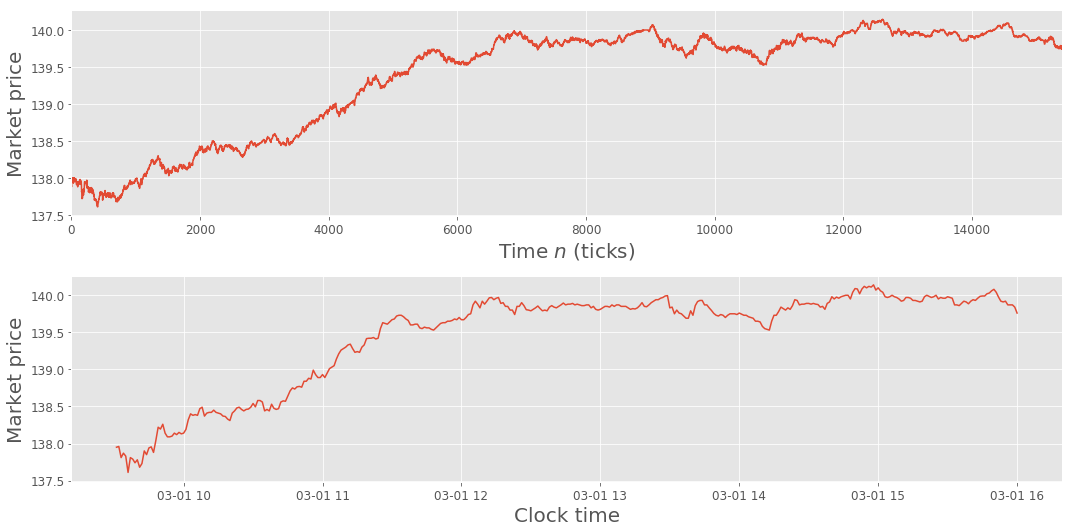

In [11]:
fig,[ax,bx]=plt.subplots(figsize=(15,7.5), nrows=2, subplot_kw={'ylabel':r'Market price'})
ax.plot(appletick.index, appletick['Last'])
bx.plot(applemin['datetime'], applemin['Close'])
ax.set_xlim(0,15398)
ax.set_xlabel('Time $n$ (ticks)')
bx.set_xlabel('Clock time')
plt.tight_layout()
plt.show()

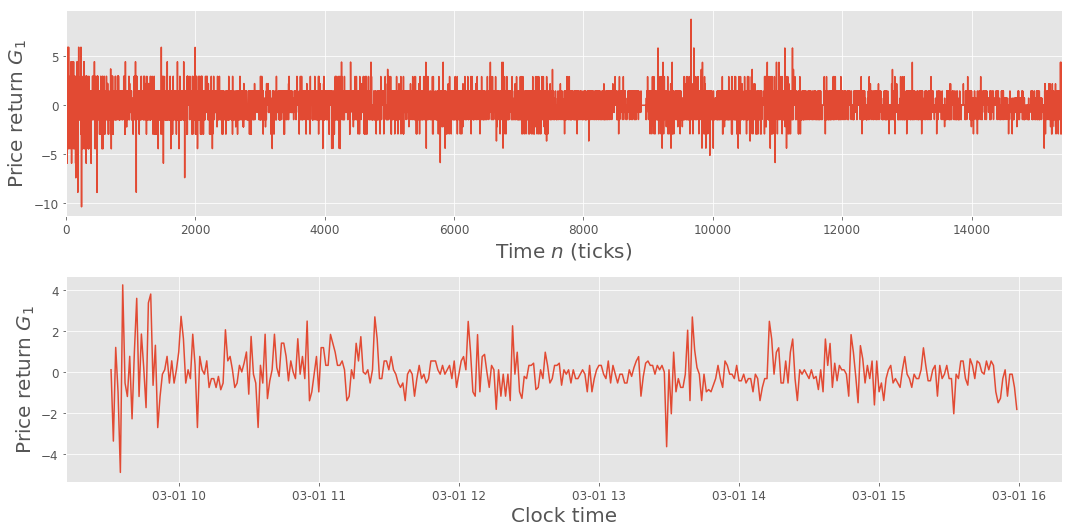

In [12]:
fig,[ax,bx]=plt.subplots(figsize=(15,7.5), nrows=2)
ax.plot(appletick.index, appletick['Return d1'])
bx.plot(applemin['datetime'], applemin['Return d1'])
ax.set_xlim(0,15398)
ax.set_ylabel(r'Price return $G_{1}$')
bx.set_ylabel(r'Price return $G_{1}$')
ax.set_xlabel('Time $n$ (ticks)')
bx.set_xlabel('Clock time')
plt.tight_layout()
plt.show()

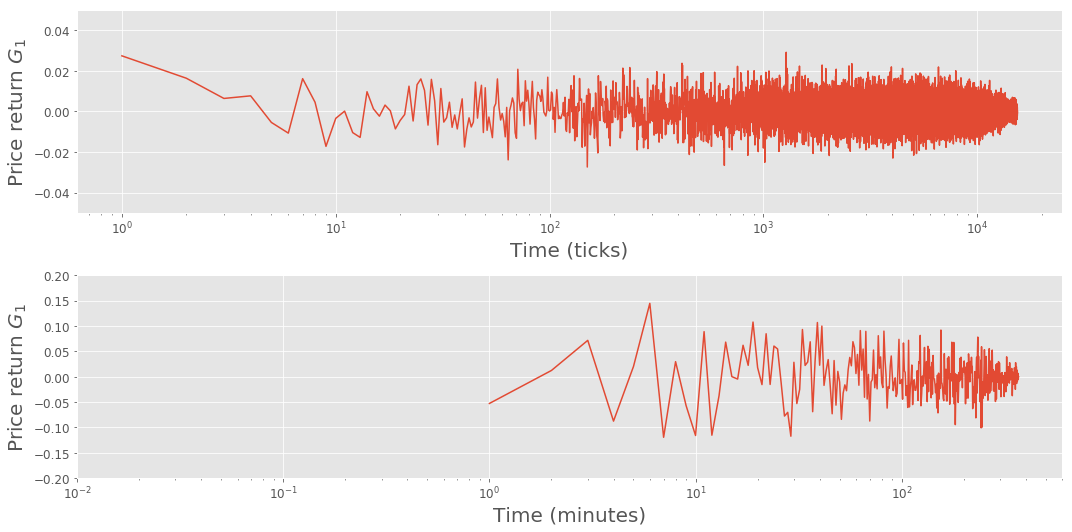

In [13]:
def computeCt(data, name):
    ct = auto_correlate(data[name].values[:-20]) # ignore NaN last point
    data['Ct'] = pd.Series(ct, index=data.index[:-20])
computeCt(appletick, 'Return d1')
computeCt(applemin, 'Return d1')
fig,[ax,bx]=plt.subplots(figsize=(15,7.5), nrows=2, subplot_kw={'ylabel':r'Price return $G_1$'})
ax.plot(appletick['Ct'])
bx.plot(applemin['Ct'])
ax.set_xlabel('Time (ticks)')
bx.set_xlabel('Time (minutes)')
ax.semilogx()
bx.semilogx()
ax.set_ylim(-0.05, 0.05)
bx.set_ylim(-0.2, 0.2)
bx.set_xlim(1e-2,6e2)
plt.tight_layout()
plt.show()

### Time-correlation of the S&P 500 returns 
<!--
<img src="fig/correlation.png" width=800>
-->
![](fig/correlation.png)
- P. Gopikrishnan, V. Plerou, L. Amaral, M. Meyer and H. Stanley <i>Physical Revew E</i> <b>60</b>, 5305 (1999).
- Time auto-correlation of $G_{\Delta t}(\tau)$ with $\Delta t = 1\textrm{min}$

# 4.5. Conclusions

- We have shown how a simple-model stochastic model, built borrowing concepts from statistical physics, can reproduce many behaviors seen in real-world stock markets.
- While we considered the simplest possible version, with only two dealers and constant and equal trend-following characteristics, you can easily remove these restrictions. You can try to simulate for hundreds of dealers, with non-constant d values. The main results still hold, it just becomes more complicated to analyze as the number of parameters increases.
- For the dealer model we presented, one can recover the non-trivial power law decay of the price returns, but only for a specific set of parameter values. If the parameters of the model are changed, then the nature of the distribution can also change.
- While this type of modeling can help you understand complex real-world systems, you should be very careful when trying to make precise quantitative predictions based on them.